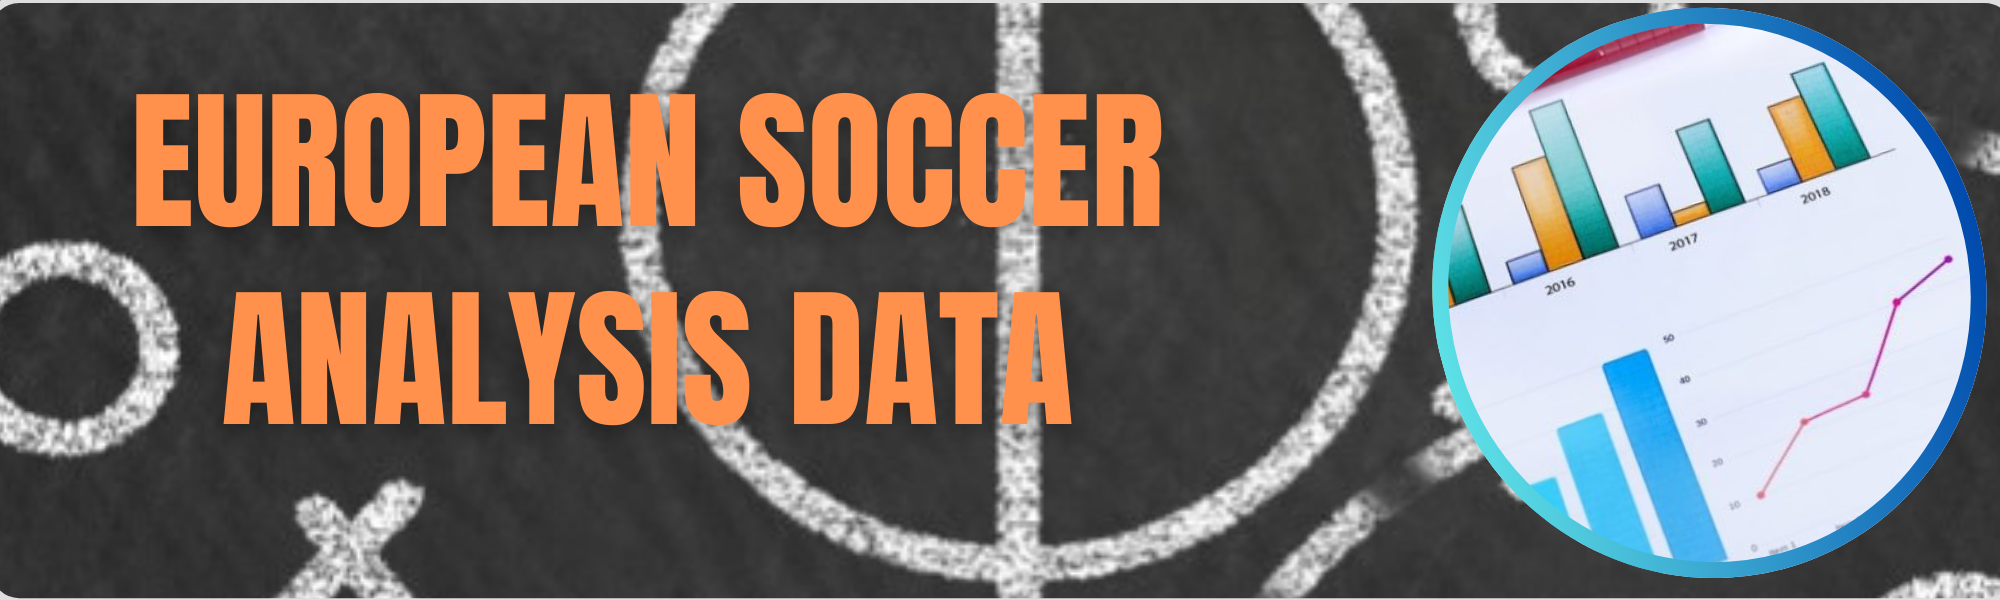


## 1. SQL Practice

In [1]:
import pandas as pd  # Library for data manipulation and analysis
import matplotlib.pyplot as plt  # Library for creating plots and visualizations
import sqlite3  # Library for working with SQLite databases
import os  # Library for interacting with the operating system

We create the function connection_database, which takes the directory path where the database is located as a parameter. If the connection is successful, it displays a message of 'Successful Connection'; otherwise, it raises an exception.

The function establishes a connection to the SQLite database specified by the given path. Upon successful connection, it prints a message indicating the successful connection. If any errors occur during the connection attempt, they are handled as exceptions and an error message is printed.

The function returns the connection object to the SQLite database, which can be used to execute queries and access table information

In [2]:
def connection_database(path):
    """
    Function to establish a connection to an SQLite database and retrieve information about tables.

    Parameters:
    path (str): The path to the SQLite database file.

    Returns:
    sqlite3.Connection: A connection to the SQLite database.
    """
    try:
        # Establish a connection to the SQLite database
        connection = sqlite3.connect(path)
        print('______The Conecction was Successful!______')

    except sqlite3.Error as e:
        # Print any errors that occur during the connection attempt
        print(e)

    # Return the connection to the SQLite database
    return connection

In [3]:
# Get the path to the database
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Iterate over the filenames in the current directory
    for filename in filenames:
        # Create the full path to the file
        path = os.path.join(dirname, filename)

# Create the connection to the database
database_connection = connection_database(path)

______The Conecction was Successful!______


This function, named `query_on_db`, is used to execute a SQL query on a specified database connection. It takes two parameters: query, which is a string representing the SQL query to be executed, and db_connection, which is the connection object to the database.

The function executes the provided SQL query on the specified database connection using the pd.read_sql() function from the Pandas library. The result of the query is stored in a DataFrame.

Finally, the function returns the DataFrame containing the result of the SQL query

In [4]:
def query_on_db(query, db_connection):
    """
    Function to execute a SQL query on a database connection.

    Parameters:
    query (str): The SQL query to be executed.
    db_connection (sqlite3.Connection): The connection to the database.

    Returns:
    pandas.DataFrame: A DataFrame containing the result of the SQL query.
    """
    # Execute the SQL query on the database connection and store the result in a DataFrame
    result = pd.read_sql(query, db_connection)
    return result


In [5]:
# Read information about tables from the SQLite database and store it in a DataFrame
# Execute SQL query to retrieve information about tables

query = """SELECT * FROM sqlite_master WHERE type = 'table';"""
tables = query_on_db(query, database_connection)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [6]:
## Example of the query_on_db function
query = """
    SELECT player_name, height, weight
    FROM Player
"""
players = query_on_db(query, database_connection)
players.head()

,player_name,height,weight
0,Aaron Appindangoye,182.88,187
1,Aaron Cresswell,170.18,146
2,Aaron Doran,170.18,163
3,Aaron Galindo,182.88,198
4,Aaron Hughes,182.88,154


We want to combine information about teams, leagues and countries.

1. **Common Table Expression (CTE)**:
   - The query begins with a `WITH` clause followed by an alias `temp`. This defines a CTE named `temp`, which is essentially a subquery that can be referenced later in the main query.
   - Inside the CTE `temp`, a selection of columns is made from the `league`, `match`, and `team` tables. These are the selected columns:
     - `T.team_long_name AS Team_name`: The long name of the team selected from the `team` table and given an alias `Team_name`.
     - `L.name AS League_name`: The name of the league selected from the `league` table and given an alias `League_name`.
     - `L.id AS League_id`: The ID of the league selected from the `league` table and given an alias `League_id`.
   - These tables are related through the following joins:
     - `JOIN Match AS M ON L.id = M.league_id`: Joins the `match` table with the `league` table using the `league_id` column.
     - `JOIN team AS T ON M.home_team_api_id = T.team_api_id`: Joins the `team` table with the `match` table using the `home_team_api_id` column.
   - The `GROUP BY` clause is used to group the results by the league name (`L.name`) and the long name of the team (`T.team_long_name`).

2. **Main Query**:
   - After defining the CTE `temp`, a main query is executed that makes use of this CTE.
   - It selects columns from the `temp` CTE and the `country` table.
   - The selected columns are:
     - `T.team_name`: The team name extracted from the `temp` CTE.
     - `T.league_name`: The league name extracted from the `temp` CTE.
     - `C.name AS Country`: The country name selected from the `country` table and given an alias `Country`.
   - A join is performed between the `temp` CTE and the `country` table using the `league_id` column.

In [7]:
query = """
        WITH temp AS
                    (
                    SELECT T.team_long_name AS Team_name,
                           L.name AS League_name,
                           L.id AS League_id
                    FROM league AS L 
                    JOIN Match AS M ON L.id = M.league_id
                    JOIN team AS T ON M.home_team_api_id = T.team_api_id
                    GROUP BY L.name, T.team_long_name
                    )
                    SELECT T.team_name,T.league_name,C.name AS Country
                    FROM temp AS T 
                    JOIN country AS C ON C.id = T.league_id
        """
Team_leagues = query_on_db(query, database_connection)
Team_leagues

,Team_name,League_name,Country
0,Beerschot AC,Belgium Jupiler League,Belgium
1,Club Brugge KV,Belgium Jupiler League,Belgium
2,FCV Dender EH,Belgium Jupiler League,Belgium
3,KAA Gent,Belgium Jupiler League,Belgium
4,KAS Eupen,Belgium Jupiler League,Belgium
...,...,...,...
291,FC Zürich,Switzerland Super League,Switzerland
292,Grasshopper Club Zürich,Switzerland Super League,Switzerland
293,Lugano,Switzerland Super League,Switzerland
294,Neuchâtel Xamax,Switzerland Super League,Switzerland


In [8]:
# Team_leagues.to_csv('team_leagues.csv', index = False)

We want to retrieves the names of players (`Player_name`) and their corresponding teams (`Team_name`) for home teams in matches by joining the `Match`, `Player`, and `Team` tables.

This SQL query retrieves data from the `Match`, `Player`, and `Team` tables to find the names of players and their corresponding teams for home teams in matches. Here's a breakdown of the query:

- `SELECT`: This clause specifies the columns to be included in the query result.
  - `P.player_name AS Player_name`: It selects the player's name from the `Player` table and renames the column as `Player_name`.
  - `T.team_long_name AS Team_name`: It selects the long name of the team from the `Team` table and renames the column as `Team_name`.

- `FROM Match AS M`: This specifies the `Match` table to be used in the query and assigns it an alias `M`.

- `JOIN Player as P ON M.home_player_1 = P.player_api_id`: This performs an inner join between the `Match` table and the `Player` table based on the condition that the `home_player_1` column in the `Match` table matches the `player_api_id` column in the `Player` table. This join associates each match with the corresponding player who played as home_player_1.

- `JOIN Team AS T ON M.home_team_api_id = T.team_api_id`: This performs another inner join, this time between the `Match` table and the `Team` table, based on the condition that the `home_team_api_id` column in the `Match` table matches the `team_api_id` column in the `Team` table. This join associates each match with the corresponding home team.

In [9]:
query = """
      SELECT
         P.player_name AS Player_name,
         T.team_long_name AS Team_name
    FROM Match AS M
    JOIN Player as P ON M.home_player_1 = P.player_api_id
    JOIN Team AS T ON M.home_team_api_id = T.team_api_id;
    """
players_and_teams = query_on_db(query, database_connection)
players_and_teams

,Player_name,Team_name
0,Mark Volders,Royal Excel Mouscron
1,Wouter Biebauw,KV Mechelen
2,Bertrand Laquait,Sporting Charleroi
3,Boubacar Barry Copa,Sporting Lokeren
4,Stijn Stijnen,Club Brugge KV
...,...,...
24750,Andris Vanins,FC Sion
24751,Daniel Lopar,FC St. Gallen
24752,Peter Jehle,FC Vaduz
24753,Vaso Vasic,Grasshopper Club Zürich


In [10]:
# players_and_teams.to_csv('players_and_teams.csv', index=False)

We want to calculates statistics related to the performance of soccer teams, including the total number of games played, the number of wins, and the win percentage.


1. **Common Table Expressions (CTEs)**:
   - The query begins with multiple CTEs, each performing specific tasks:
   
   - `temp`: This CTE selects various columns from the `Match` table along with some additional derived columns such as determining the winner based on home and away goals. It utilizes left joins with the `Team` table twice to get the long names of the home and away teams.
   
   - `home`: This CTE calculates the number of home games played by each team by counting the occurrences of each team appearing as the home team in the `temp` CTE.
   
   - `away`: Similar to `home`, this CTE calculates the number of away games played by each team by counting the occurrences of each team appearing as the away team in the `temp` CTE.
   
   - `total`: This CTE calculates the total number of games played by each team by summing up the home and away games calculated in the `home` and `away` CTEs respectively. It joins the `home` and `away` CTEs on team IDs to combine the results.
   
   - `wins`: This CTE calculates the number of wins for each team by counting the occurrences of each team ID being marked as the winner in the `temp` CTE.

2. **Main Query**:
   - The main query selects columns from the `total` and `wins` CTEs.
   
   - It calculates the win percentage for each team by dividing the number of wins by the total number of games and multiplying by 100.
   
   - The results are ordered by the number of wins in descending order.

In [11]:
query = """ 
        WITH temp AS (
             SELECT m.match_api_id, 
                    ht.team_long_name AS  home_team,
                    AT.team_long_name AS away_team,
                    home_team_goal, 
                    away_team_goal,
                    ht.team_api_id AS h_id,
                    at.team_api_id AS a_id,
             CASE 
                    when m.home_team_goal > m.away_team_goal then ht.team_api_id
                    when m.home_team_goal < m.away_team_goal then at.team_api_id else 'Tie' end as winner
                FROM Match AS m
                LEFT JOIN Team AS ht on ht.team_api_id = m.home_team_api_id
                LEFT JOIN Team AS at on at.team_api_id = m.away_team_api_id
            ),
            home AS (
                        
                SELECT COUNT(match_api_id) AS home_games,
                       home_team AS team_name,
                       h_id
                FROM temp
                GROUP BY home_team 
                ),
             away AS (
                SELECT COUNT(match_api_id) AS away_games,
                       away_team AS team_name,
                       a_id
                FROM temp
                GROUP BY away_team
                ),
              total AS (
                SELECT a.away_games + h.home_games AS total_games,
                       h.team_name,
                       h.h_id
                FROM home AS h 
                JOIN away AS a ON h.h_id = a.a_id
                GROUP BY h.team_name
                ),
               wins AS (
                 SELECT winner, COUNT(*) AS wins
                 FROM temp
                 GROUP BY winner 
                )
               SELECT t.total_games,
                      t.team_name,
                      w.wins,
                      (w.wins)*100/(t.total_games) AS win_percentage
               FROM total AS t
               JOIN wins AS w on t.h_id = w.winner
               ORDER BY wins DESC
                    """

In [12]:
team_performances = query_on_db(query, database_connection)
team_performances

,total_games,team_name,wins,win_percentage
0,304,FC Barcelona,234,76
1,304,Real Madrid CF,228,75
2,304,Celtic,218,71
3,272,FC Bayern Munich,193,70
4,304,Manchester United,192,63
...,...,...,...,...
290,34,FC Dordrecht,4,11
291,34,SpVgg Greuther Fürth,4,11
292,34,DSC Arminia Bielefeld,4,11
293,38,Córdoba CF,3,7


In [13]:
# team_performances.to_csv('team_performances.csv', index=False)

## 2. Data Visualization

In [14]:
from IPython.display import IFrame

# Import Tableau Visualization 
IFrame('https://public.tableau.com/views/Analysissoccerteams/Dashboard1?::embed=y&:display_count=yes&:showVizHome=no', width= 950, height = 1000)